In [234]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### imports

In [294]:
print(__doc__)

import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import entropy
from sklearn import preprocessing
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.feature_extraction.text import CountVectorizer

Automatically created module for IPython interactive environment


### utilities

In [328]:
def sigmoid(x):
    return 1 / (1 + (np.e**-x))
                
def clean_documents(docs):
    def clean_doc(doc):
        ''' remove unwanter characters line new line '''

        unwanted_chrs = [')', '(', '{', '}', '\t', '\n', '\r', "'", '"', "!"]
        for unwanted_chr in unwanted_chrs:
            doc = doc.replace(unwanted_chr, ' ')

        return doc.strip()
    
    return [clean_doc(doc) for doc in docs]

### load dataset

In [329]:
# total number of samples needed
datasize = 1000

# retrieve dataset
docs = fetch_20newsgroups(subset='train', shuffle=False, remove=('headers', 'footers', 'quotes'))
docs, labels, classes = docs.data[:datasize], docs.target[:datasize], docs.target_names

In [330]:
# the actual labels as np array
labels = np.array(labels)

# the new classes
label_classes = list(set([x.split('.')[0] for x in classes]))

# restructuring classes  from 19 to less
for label, cl in enumerate(classes):
    labels[labels == label] = label_classes.index(cl.split('.')[0])

In [331]:
print(f"there are {len(docs)} docs and {len(label_classes)} classes")

there are 1000 docs and 7 classes


### clean dataset

In [332]:
# clean out the new line characters from text in docs
clean_docs = clean_documents(docs)
clean_docs[0]

'morgan and guzman will have era s 1 run higher than last year, and  the cubs will be idiots and not pitch harkey as much as hibbard.  castillo won t be good  i think he s a stud pitcher'

### count words

In [333]:
# initialize the count vectorizer
count_vectorizer = CountVectorizer()

# fit it to dataset
count_vectorizer.fit(clean_docs)

# create dataset
word_count = pd.DataFrame(count_vectorizer.vocabulary_, index=[0])

print("word_count shape is", word_count.shape)

word_count shape is (1, 19476)


In [334]:
word_count.head()

,morgan,and,guzman,will,have,era,run,higher,than,last,...,optilink,molested,w4wg,lastdrive,refund,lurch,conical,cornea,skysweepers,skies
0,12098,2746,8904,19022,9063,7336,15421,9215,17511,10791,...,12940,12042,18740,10792,14779,11250,5281,5505,16267,16249


### Prepare Datatset

In [335]:
# create doc count vectors
doc_vectors = count_vectorizer.transform(clean_docs).toarray()

# # get indices of empty docs
# indices = np.where(doc_vectors.sum(1) == 0)[0]

# # remove empty docs
# docs = np.delete(docs, indices, 0)
# labels = np.delete(labels, indices, 0)
# clean_docs = np.delete(clean_docs, indices, 0)
# doc_vectors = np.delete(doc_vectors, indices, 0)

data = pd.DataFrame(doc_vectors, columns=count_vectorizer.get_feature_names())
data["__labels__"] = labels

print("data shape is", data.shape)

data shape is (1000, 19477)


In [336]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes")

there are 1000 docs and 7 classes


In [337]:
data.head()

,00,000,0000,00000000,00000000b,00000001,00000001b,00000010,00000010b,00000011,...,zoom,zoomed,zooming,zubov,zum,zupancic,zx,zx900a,zzz,__labels__
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


### Cherry pick dataset

In [338]:
# trim the data to words that spread round the corpus

#reduce freq in doc to bin value of 1 or 0
word_doc_binary_freqency = (data.drop(["__labels__"], axis='columns') > 0).astype('int')

#the sum vertically of bin freq
word_doc_frequency = word_doc_binary_freqency.sum(0) 

#the frequency of word across docs
selected_words = word_doc_frequency[word_doc_frequency >= word_doc_frequency.mean()].index.tolist()

# the new and more informative dataset
selected_data = data[selected_words + ["__labels__"]]

print("selected_data shape is", selected_data.shape)

selected_data shape is (1000, 3043)


In [339]:
selected_data.head()

,00,000,04,10,100,1000,101,11,12,120,...,york,you,young,your,yours,yourself,zero,zip,zone,__labels__
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,3
2,0,0,0,2,0,0,0,3,1,0,...,1,1,0,0,0,0,0,1,0,6
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [367]:
topic = 3
word_topic_co = (word_doc_binary_freqency[data['__labels__'] == topic].sum(0) * sigmoid(word_doc_frequency)) / word_doc_frequency
word_topic_co.shape

(19476,)

In [419]:
word_topic_co[word_topic_co > .5].sort_values()

tried       0.511628
running     0.515152
help        0.518987
lines       0.526316
computer    0.527778
              ...   
reset       0.997527
mouse       0.999089
font        0.999089
fonts       0.999665
motif       0.999983
Length: 3164, dtype: float64

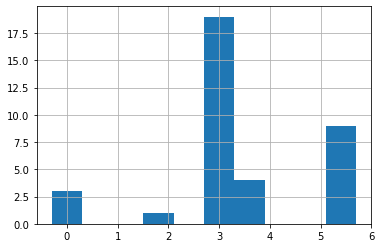

In [420]:
word = "computer"
data[word_doc_binary_freqency[word] > 0]["__labels__"].hist(align="left")

In [374]:
word = 'application'
data[data[word] > 0][[word, "__labels__"]]

,application,__labels__
6,3,3
14,2,3
70,1,6
76,1,3
85,1,3
101,2,3
105,2,3
209,1,3
241,1,6
247,2,3


In [190]:
label_classes

['rec', 'alt', 'soc', 'comp', 'misc', 'talk', 'sci']